In [2]:
import os, sys
import healpy as hp
import numpy as np

sys.path.append('../../')
sys.path.append('/DMASS-analysis/measurements/code_py3/')

import esutil
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from utils import *

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

os.chdir('/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3/')
print(os.getcwd())

from calling_catalogs import *
from sys_functions import *

rootdir = '/users/PCON0003/warner785/DMASS-analysis/measurements/clustering/'

from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


/users/PCON0003/warner785/DMASS-analysis/measurements/code_py3


In [2]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [3]:
# for dmass spt

dmass_spt = calling_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')
#dmass_spt = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/dmass_spt.fits')
#random_spt = uniform_random_on_sphere(dmass_spt, size = 10*int(np.sum(dmass_spt['CMASS_PROB']))) 
#random_spt = keepGoodRegion(random_spt)
#random_spt = appendColumn(random_spt, value=np.ones(random_spt.size), name='CMASS_PROB')
random_chron = esutil.io.read('/users/PCON0003/warner785/DMASSY3/code_py3/random_spt_chron.fits')
index_mask = np.argsort(dmass_spt)
dmass_chron = dmass_spt[index_mask] # ordered by hpix values

#outdir = '/fs/scratch/PCON0008/warner785/bwarner/oct23_tests/'
#esutil.io.write(outdir+'dmass_spt_chron.fits', dmass_chron, overwrite=True)

Resulting catalog size
DMASS= 341117.6414259936


In [ ]:
# Send to NERSC:
# /users/PCON0003/warner785/DMASSY3/code_py3/random_spt_chron.fits
# /fs/scratch/PCON0008/warner785/bwarner/oct23_tests/dmass_spt_chron.fits
# /fs/scratch/PCON0008/warner785/bwarner/june23_tests/final27.fits

In [4]:
quad_weight = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/oct23_tests/'+'SPfinal19.fits') #sp weights
lin_weight = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/june23_tests/'+'final27.fits')

#quad = finalq32 --- june23
#lin = final27
qweights = dmass_chron["CMASS_PROB"]*quad_weight
lweights = dmass_chron["CMASS_PROB"]*lin_weight

In [7]:
# load in CMASS later:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/matched_cmass.fits')

print(cmass.size)

60037


In [4]:
# checking y1 dmass:
y1_dmass = calling_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_y1_public_v1.fits')
randoms = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/random_dmass_y1_public_v1.fits')

Resulting catalog size
DMASS= 117292.90214602613


In [5]:
randoms = appendColumn(randoms, value=np.ones(randoms.size), name='CMASS_PROB')

In [8]:
print(y1_dmass.dtype.names)
print(randoms.dtype.names)

y1_dmass = y1_dmass[y1_dmass['VETO']!=0]
randoms = randoms[randoms['VETO']!=0]

('COADD_OBJECTS_ID', 'RA', 'DEC', 'VETO', 'CMASS_PROB', 'WEIGHT_SYS')
('RA', 'DEC', 'VETO', 'CMASS_PROB')


In [8]:
randomsind_create = np.random.choice( random_create.size, size=int(random_create.size/3.) )
random_create = random_create[randomsind_create]

In [5]:
def treecorr_xi(lens, random=None, filename=None, rootdir=None, 
		nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.05, 
        npatch=10, var_method='jackknife', cen_file = None, w = None):
    
    import treecorr

    if cen_file != None:
        if os.path.exists(cen_file):
            print ('Saved cen_file exists:',cen_file)
            cen_file_switch_on = cen_file
            npatch=1
        else : 
            print ('Create cen_file=',cen_file)
            cen_file_switch_on = None

    #temp_dir=filename.split('.txt')[0]
    #lens['CMASS_PROB']*lens['WEIGHT_SYS']
    cat_l = treecorr.Catalog(ra=lens['RA'], dec=lens['DEC'], w=w, 
                             ra_units='deg', dec_units='deg', npatch=npatch, 
                             patch_centers=cen_file_switch_on )

    if cen_file_switch_on == None : 
        cat_l.write_patch_centers(cen_file)
#changed to make weights = 1 for randoms
    #from numpy.lib.recfunctions import append_fields
    #weights = np.zeros(len(random))
    #for x in range(len(random)-1):
        #weights[x]=1
    #random = append_fields(random, 'WEIGHT', weights, usemask=False)
    
    cat_r = treecorr.Catalog(ra=random['RA'], dec=random['DEC'], w=random['CMASS_PROB'], 
                             ra_units='deg', dec_units='deg', 
                             patch_centers=cen_file_switch_on )
    
    dd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                            max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                            var_method=var_method,
                            num_threads=30, verbose=1)
    dr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)

    dd.process(cat_l)
    dr.process(cat_l, cat_r)
    rd.process(cat_r, cat_l)
    rr.process(cat_r)
    xi,varxi = dd.calculateXi(rr,dr)
    dd.write(filename,rr,dr,rd)
    
    cov_jk = dd.estimate_cov(var_method)
    cov_filename=filename.split('.txt')[0]+'.cov'
    np.savetxt(cov_filename, cov_jk)
    
    print ('save to', filename)
    
# search for VETO in run_DMASS
# ask Su about this, if not

In [ ]:
npatch=80
tempdir = rootdir+'/{}/'.format(npatch)
cen_file = tempdir + 'nn_cen_file_lin.txt'
filename = tempdir + 'nn.lens_lin.txt'

#os.system('mkdir '+savedir)
#print (os.path.exists(tempdir) )
os.system('rm -rf '+tempdir)
os.system('mkdir '+tempdir)

# default of poisson errors -- try this
# ***save to different variables to compare different methods of errors

treecorr_xi(dmass_chron, random=random_spt,
        filename=filename, rootdir = tempdir, 
        nbins=20, min_sep=2.5, max_sep=250., sep_units='arcmin', bin_slop=0.05,
        npatch=npatch, cen_file=cen_file, var_method='jackknife', w = lweights)

cov_lin_dmass= np.genfromtxt(tempdir+'/nn.lens_lin.cov'.format(npatch))
_, meanr, _, galaxy_xi, xi_err,_,_,_,_,_ = np.genfromtxt(tempdir+'nn.lens_lin.txt'.format(npatch), unpack=True)

Create cen_file= /users/PCON0003/warner785/DMASS-analysis/measurements/clustering//80/nn_cen_file_lin.txt


In [ ]:
#cov_lin_dmass= np.genfromtxt(tempdir+'/nn.lens_lin.cov'.format(npatch))
#_, meanr, _, galaxy_xi, xi_err,_,_,_,_,_ = np.genfromtxt(tempdir+'nn.lens_lin.txt'.format(npatch), unpack=True)

In [ ]:
npatch=80
tempdir = rootdir+'/{}/'.format(npatch)
cen_file = tempdir + 'nn_cen_file_quad.txt'
filename = tempdir + 'nn.lens_quad.txt'

#os.system('mkdir '+savedir)
#print (os.path.exists(tempdir) )
os.system('rm -rf '+tempdir)
os.system('mkdir '+tempdir)

# default of poisson errors -- try this
# ***save to different variables to compare different methods of errors

treecorr_xi(dmass_chron, random=random_spt,
        filename=filename, rootdir = tempdir, 
        nbins=20, min_sep=2.5, max_sep=250., sep_units='arcmin', bin_slop=0.05,
        npatch=npatch, cen_file=cen_file, var_method='jackknife', w = qweights)

cov_quad_dmass= np.genfromtxt(tempdir+'/nn.lens_quad.cov'.format(npatch))
_, meanr_quad, _, galaxy_xi_quad, xi_err_quad,_,_,_,_,_ = np.genfromtxt(tempdir+'nn.lens_quad.txt'.format(npatch), unpack=True)

In [11]:
# read in Su's data:

wtheta_su = np.array([[2.80504614e+00, 2.04160000e-01],
 [3.53134386e+00, 1.71170000e-01],
 [4.44569853e+00, 1.47430000e-01],
 [5.59680285e+00, 1.25550000e-01],
 [7.04595733e+00, 1.05600000e-01],
 [8.87033473e+00, 8.70390000e-02],
 [1.11670898e+01, 7.65390000e-02],
 [1.40585331e+01, 6.24190000e-02],
 [1.76986446e+01, 5.21800000e-02],
 [2.22812735e+01, 4.21460000e-02],
 [2.80504614e+01, 3.38060000e-02],
 [3.53134386e+01, 2.75830000e-02],
 [4.44569853e+01, 2.07170000e-02],
 [5.59680285e+01, 1.57440000e-02],
 [7.04595733e+01, 1.27630000e-02],
 [8.87033473e+01, 9.31180000e-03],
 [1.11670898e+02, 6.26490000e-03],
 [1.40585331e+02, 3.96460000e-03],
 [1.76986446e+02, 2.31330000e-03],
 [2.22812735e+02, 6.60470000e-04]])

In [12]:
print(wtheta_su[0][1])
print(wtheta_su.shape)

0.20416
(20, 2)


In [13]:
meanr_su = []
galaxy_xi_su = []
for x in range(20):
    meanr_su.append(wtheta_su[x,0])
    galaxy_xi_su.append(wtheta_su[x,1])

In [8]:
#quad_values:
#galaxy_quad_xi = np.array([0.20676,    0.17854,    0.15096,    0.12711,    0.10749,    0.089998,
# 0.080127,   0.067453,   0.054575,   0.044821,   0.03759,    0.029642,
# 0.023316,   0.017626,   0.013533,   0.0087504,  0.0059748,  0.0032934,
# 0.0017972,  0.00086548])

In [ ]:
# load in textfile to make cmass covariance errors:
nz = np.loadtxt('/users/PCON0003/warner785/DMASSY3/test_dmass_v3_llll_cov_Ntheta20_Ntomo0_1')

# Creates a list containing 20 lists, each of 20 items, all set to 0
w, h = 20, 20
Matrix = [[0 for x in range(w)] for y in range(h)] 
for i in range(h*20):
    x = int(nz[i][0])
    y = int(nz[i][1])
    #print(x,y)
    Matrix[x][y]= nz[i][8]
matrix = np.array(Matrix)  

In [ ]:
print(matrix)
diag_cov = np.diagonal(matrix)
error = np.sqrt(diag_cov)

In [ ]:
delta_w = galaxy_xi_quad-galaxy_xi
diff_chi2, diff_chi2_reduced = chi2(delta_w, np.zeros(20), None, 0, matrix, SPT = True)
print(diff_chi2, diff_chi2_reduced)

In [13]:
#or (same meaning):
d_chi2, d_chi2_reduced = chi2(galaxy_xi_quad, galaxy_xi, None, 0, matrix, SPT = True)
print(d_chi2, d_chi2_reduced)

415.0045415882251 20.750227079411253


In [19]:
print(galaxy_xi)
print()
print(galaxy_xi_quad)
print()
print(meanr)
diff =  galaxy_xi_quad-galaxy_xi
print(diff)

[0.21258    0.17447    0.14697    0.12524    0.10448    0.092308
 0.075085   0.064807   0.05175    0.043392   0.035848   0.027541
 0.020903   0.015959   0.01228    0.0079024  0.005254   0.0030519
 0.0014336  0.00040232]

[0.26344    0.17617    0.14757    0.12552    0.10435    0.09161
 0.074497   0.06376    0.051244   0.042873   0.035179   0.02709
 0.020476   0.015633   0.011809   0.0075114  0.0049574  0.0029263
 0.0013331  0.00030597]

[  2.8329   3.5681   4.4921   5.6564   7.1203   8.9651  11.286   14.207
  17.889   22.519   28.351   35.693   44.933   56.572   71.217   89.657
 112.87   142.1    178.89   225.21  ]
[ 5.086e-02  1.700e-03  6.000e-04  2.800e-04 -1.300e-04 -6.980e-04
 -5.880e-04 -1.047e-03 -5.060e-04 -5.190e-04 -6.690e-04 -4.510e-04
 -4.270e-04 -3.260e-04 -4.710e-04 -3.910e-04 -2.966e-04 -1.256e-04
 -1.005e-04 -9.635e-05]


In [ ]:
fig, ax = plt.subplots()

quad_trun = galaxy_xi_quad #[1:]
lin_trun = galaxy_xi #[1:]
err_trun = error #[1:]
r_trun = meanr #[1:]

#ax.loglog(theta, galaxy_xi_theory)
#ax.errorbar( meanr_su, galaxy_xi_su)
ax.errorbar( r_trun, quad_trun-lin_trun, err_trun)
#ax.errorbar( meanr, galaxy_xi, xi_err)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.axhline(y=0, color='grey', linestyle='--')

In [23]:
d_chi2, d_chi2_reduced = chi2(quad_trun, lin_trun, None, 0, matrix, SPT = True)
print(d_chi2, d_chi2_reduced)

ValueError: shapes (1,19) and (20,20) not aligned: 19 (dim 1) != 20 (dim 0)

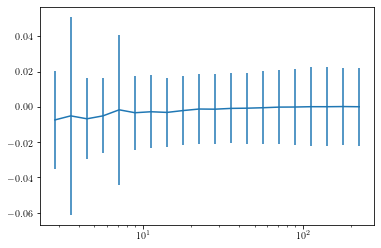

In [14]:
# difference of dmass with and without prob cut

fig, ax = plt.subplots()

ax.errorbar( meanr, (galaxy_xi-galaxy_xi_cut), xi_err )
ax.set_xscale('log')

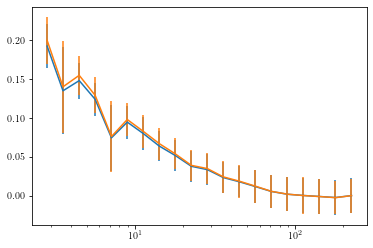

In [15]:
# difference of dmass with and without prob cut

fig, ax = plt.subplots()

ax.errorbar( meanr, galaxy_xi, xi_err )
ax.errorbar( meanr_cut, galaxy_xi_cut, xi_err_cut )
ax.set_xscale('log')